# Linear Regression - Ridge Regression

**Problem**: Using housing data, we will attempt to predict house price using living area with a regression model.  

**Data**: Data comes from [Kaggle's House Prices Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).  

See above link for Description of data.

<a id = "data"></a>  
### Data Exploration

Below provides a review of the "Housing" dataset.

In [1]:
# Importing dependencies
%matplotlib inline 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [2]:
# Setting plotting parameters for display 
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [7]:
# Read in the data
train_path = 'Resources/train.csv'
test_path = 'Resources/test.csv'

data = pd.read_csv(train_path)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
for column in data:
    if data[column].isnull().any():
        print('{0} has {1} null values'.format(column, data[column].isnull().sum()))

LotFrontage has 259 null values
Alley has 1369 null values
MasVnrType has 8 null values
MasVnrArea has 8 null values
BsmtQual has 37 null values
BsmtCond has 37 null values
BsmtExposure has 38 null values
BsmtFinType1 has 37 null values
BsmtFinType2 has 38 null values
Electrical has 1 null values
FireplaceQu has 690 null values
GarageType has 81 null values
GarageYrBlt has 81 null values
GarageFinish has 81 null values
GarageQual has 81 null values
GarageCond has 81 null values
PoolQC has 1453 null values
Fence has 1179 null values
MiscFeature has 1406 null values


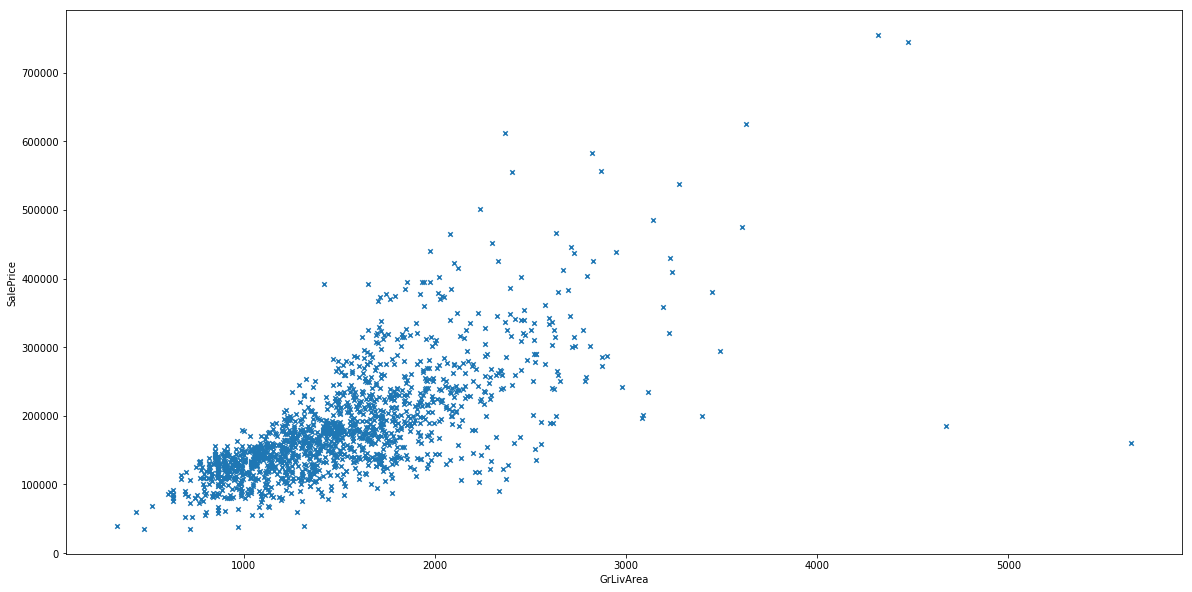

In [11]:
data.plot('GrLivArea', 'SalePrice', kind = 'scatter', marker = 'x');

In [15]:
data[['Street','Alley']].head(10)

,Street,Alley
0,Pave,NaN
1,Pave,NaN
2,Pave,NaN
3,Pave,NaN
4,Pave,NaN
5,Pave,NaN
6,Pave,NaN
7,Pave,NaN
8,Pave,NaN
9,Pave,NaN


# Coding Ridge Regression**

### ** Preprocessing**

Before implementing Ridge Regression, it is important to mean-center our target variable and mean-center and standardize observations. We will do this according to the following:

### **Mean Center Target**
$$y_{cent} = y_0 - \bar{y}$$
### **Standardize Observations**
$$X_{std} = \frac{X_0-\bar{X}}{s_{X}}$$
Where $\bar{X}$ is the sample mean of X and $s_{X}$ is the sample standard deviation of X

*** Centering / standarization transformations are important because Ridge penalizes large coefficients; the transformations make the coefficiets of similar scale.***

In [16]:
### We will take one input, a list of numbers and will return a list where those values have been standardized.
### To standardize, we will subtract the mean of the list and divide by standard deviation using np.std for calculating standard deviation

def standarize(num_list):
    #Calculating standard deviation and mean 
    std = np.std(num_list)
    mean = np.mean(num_list)
    
    #Implement equation
    toRet = [(x-mean)/std for x in num_list]
    
    return toRet

Below we will create a function which will preprocess our data by performing:

* mean subtraction from $y$, 
* dimension standardization for $x$.

Both according to the equations set out below.

### Mean Center Target

$$y_{cent} = y_0 - \bar{y}$$

### Standardize Observations

$$X_{std} = \frac{X_0-\bar{X}}{s_{X}}$$

In [19]:
def preprocess_for_regularization(data, y_column_name, x_column_names):

    data_preprocess = pd.DataFrame({})
    y_bar = np.mean(data[y_column_name]) 
    y_cent_list = []
    for name in x_column_names:
        data_preprocess[name] = standardize(data[name])
        
    for y in data[y_column_name]:       
        y_cent = (y - y_bar)
        y_cent_list.append(y_cent)
    data_preprocess[y_column_name] = y_cent_list
    
    return data_preprocess

Next, we'll implement the equation for ridge regression using the closed form equation:  

$$w_{RR}=(\lambda+X^TX)^{-1}X^Ty$$  

We will use several `numpy` matrix functions. e.g. `np.matmul`, `np.linalg.inv`, `np.ones`, `np.transpose`, and`np.identity`.

The main change from Least Squares Regression is that $\lambda$ is a parameter *we* must set. This is different from the $w$ parameters that we calculate from either closed form or approximation algorithms.  

In [20]:
def ridge_regression_weights(input_x, output_y, lambda_param):

    output_y = output_y.reshape(1, output_y.shape[0])
    x_shape = input_x.shape
    y_shape = output_y.shape
    if x_shape[0] < x_shape[1]:
        input_x = np.transpose(input_x)
    if y_shape[0] < y_shape[1]:
        target_y = np.transpose(output_y)
        
    n = input_x.shape[0]
    ones_array = np.ones((n, 1))
    
    input_X = np.concatenate((ones_array, input_x), axis=1)

    I = np.identity(input_X.shape[1])
    
    w = np.linalg.solve((lambda_param*I + np.matmul(input_X.T, input_X)), np.dot(input_X.T, target_y))
    
    w = np.concatenate(w)
    
    return w

#### Selecting the $\lambda$ parameter

Now we will create a hyper-parameter tuning algorithm.  

In ridge regression, we must pick a value for $\lambda$. We have some intuition about $\lambda$ from the equations that define it: small values tend to emulate the results from Least Squares, while large values will reduce the dimensionality of the problem. But the choice of $\lambda$ can be motivated with a more precise quantitative treatment.

Eventually, we will look to choose the value of $\lambda$ that minimizes validation error, which we will determine using $k$-fold cross-validation.

For this example here, we will solve a simpler problem: Find a value that minimizes the mean of the list returned by a function.

In [21]:
def minimize( passed_func):
    """
    We will create a function that takes a single number (between 0 and 50 exclusive)
            as input, and returns a list of 1000 floats.
        
    """
    test_values = list(np.linspace(.1,49.9, 1000))
    returned_values = [abs(np.mean(passed_func(x))) for x in test_values]
    min_mean = min(returned_values)
    output = test_values[returned_values.index(min_mean)]
    
    return output

The above simulates hyper parameter tuning.  

In the case of ridge regression, we would be searching lambda parameters to minimize validation error.  

The `hidden` function would be analogous to the model building; the returned list analogous to residuals; and the mean of that list analogous to validation error.  


In [23]:
def lambda_search_func(lambda_param):
    
    # Define X and y
    # with preprocessing
    df = preprocess_for_regularization(data.head(50),'SalePrice', ['GrLivArea','YearBuilt'])
    
    y_true = df['SalePrice'].values
    X = df[['GrLivArea','YearBuilt']].values
    
    # Calculate Weights then use for predictions
    weights = ridge_regression_weights(X, y_true, lambda_param )
    y_pred = weights[0] + np.matmul(X,weights[1:])
    
    # Calculate Residuals
    resid = y_true - y_pred
    
    # take absolute value to tune on mean-absolute-deviation
    # Alternatively, could use:
    # return resid **2-S
    # for tuning on mean-squared-error
    
    return abs(resid)

minimize(lambda_search_func)    # --> about 1.4957957957957957

2.9414414414414414

Cross- validation is useful to minimize the likelihood of overfitting.
<a id = "sklearn"></a>

### Ridge Regression in `sklearn`  

Below gives the syntax for implementing ridge regression in sklearn.


In [24]:
from sklearn.linear_model import Ridge, LinearRegression

### Note, the "alpha" parameter defines regularization strength.
### Lambda is a reserved word in `Python` -- Thus "alpha" instead

### An alpha of 0 is equivalent to least-squares regression
lr = LinearRegression()
reg = Ridge(alpha = 100000)
reg0 = Ridge(alpha = 0)

# Notice how the consistent sklearn syntax may be used to easily fit many kinds of models
for m, name in zip([lr, reg, reg0], ["LeastSquares","Ridge alpha = 100000","Ridge, alpha = 0"]):
    
    m.fit(data[['GrLivArea','YearBuilt']], data['SalePrice'])
    print(name, "Intercept:", m.intercept_, "Coefs:",m.coef_,"\n")

LeastSquares Intercept: -2024976.362585636 Coefs: [  95.16733349 1045.86241944] 

Ridge alpha = 100000 Intercept: -1876820.7548806786 Coefs: [ 96.01060155 970.05661101] 

Ridge, alpha = 0 Intercept: -2024976.3625856338 Coefs: [  95.16733349 1045.86241944] 



Note, in the above example, an alpha of 100,000 is set for the ridge regularization. The reason an alpha value this high is required is because standardization / mean centering of our inputs did not occur, and instead of working with inputs on the order of [-4,4] we are on the interval of [0,2000].  

* Above, the coefficent around 95/96 corresponds with Living Area
* A larger "alpha" corresponds to a greater amount of regularization